In [1]:
import pandas as pd
import numpy as np

import random 

import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from fbprophet import Prophet
from pandas_datareader import data
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import FixedFormatter, FixedLocator

from scipy.sparse import csr_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
!pip install tldextract

     |████████████████████████████████| 87 kB 980 kB/s            


In [3]:
import tldextract
data = pd.read_csv("../input/phishing-site-urls/phishing_site_urls.csv")

In [4]:
data.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [5]:
def count_digits(string):
    total_number = 0
    for char_ in list(map(str, "0123456789")):
        total_number += string.lower().count(char_)
    return total_number

def count_letter(string):
    total_letter = 0
    for char_ in list(map(str, "abcdefghijklmnopqrstuvwxyz")):
        total_letter += string.lower().count(char_)
    return total_letter 
                
    
features = ["total_digits_domain", "total_digits_path", "total_digits_url", 
               "total_letter_domain", "total_letter_path", "total_letter_url",
               "len_domain", "len_url", "len_path"]


new_data = {"len_domain": [], 
            "len_path": [],
            "len_url": [], 
            "total_digits_domain": [],
            "total_digits_path": [], 
            "total_digits_url": [],
            "total_letter_domain": [],
            "total_letter_path": [], 
            "total_letter_url": []}
for index, current in enumerate(data["URL"]):
    url_split = current.split("/", 1)
    if len(url_split) == 2:
        domain, path = url_split[0], url_split[1]
    else:
        domain, path = url_split[0], ""
   
    new_data["total_digits_domain"].append(count_digits(domain))
    new_data["total_digits_path"].append(count_digits(path))
    new_data["total_digits_url"].append(count_digits(current))
    
    new_data["total_letter_domain"].append(count_letter(domain))
    new_data["total_letter_path"].append(count_letter(path))
    new_data["total_letter_url"].append(count_letter(current))
    
    new_data["len_domain"].append(len(domain))
    new_data["len_path"].append(len(path))
    new_data["len_url"].append(len(current))

In [6]:
for feature in features:
    data[feature] = new_data[feature]

In [7]:
data.head(10)

,URL,Label,total_digits_domain,total_digits_path,total_digits_url,total_letter_domain,total_letter_path,total_letter_url,len_domain,len_url,len_path
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,0,58,58,8,127,135,9,225,215
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,0,1,1,13,52,65,15,81,65
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,0,47,47,15,96,111,16,177,160
3,mail.printakid.com/www.online.americanexpress....,bad,0,0,0,16,36,52,18,60,41
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,0,21,21,18,64,82,19,116,96
5,smilesvoegol.servebbs.org/voegol.php,bad,0,0,0,23,9,32,25,36,10
6,premierpaymentprocessing.com/includes/boleto-2...,bad,0,7,7,27,20,47,28,61,32
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad,0,4,4,18,27,45,19,60,40
8,super1000.info/docs,bad,4,0,4,9,4,13,14,19,4
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad,0,35,35,18,114,132,19,193,173


In [8]:
def get_histplot_central_tendency(df: dict, fields: list, target: str):
    colors = sns.color_palette('cool')
    for field in fields:
        f, (ax1) = plt.subplots(figsize=(10, 3), dpi=100)
        v_dist_1 = df[field].values
        
        for spline in ['top', 'right', 'left']:
            ax1.spines[spline].set_visible(False)
        
        sns.histplot(v_dist_1, ax=ax1, palette=colors, kde=True)

        mean=df[field].mean()
        median=df[field].median()
        mode=df[field].mode().values[0]

        ax1.axvline(mean, color='r', linestyle='--', label="Mean")
        ax1.axvline(median, color='g', linestyle='-', label="Mean")
        ax1.axvline(mode, color='b', linestyle='-', label="Mode")
        ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
        ax1.set_xlabel(f'count', fontsize=13, color = '#333F4B')
        ax1.set_ylabel(f'{field}', fontsize=13, color = '#333F4B')
        ax1.legend()
        plt.grid(False)
        plt.plot(color="white", lw=3)
        f.suptitle(f"Representation Histogram for {field} - {target}", fontsize=18)

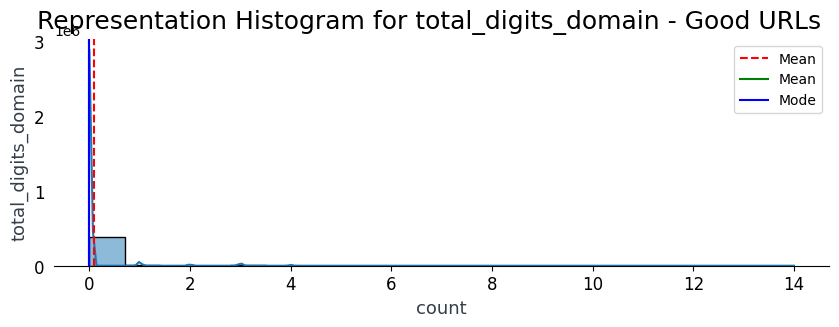

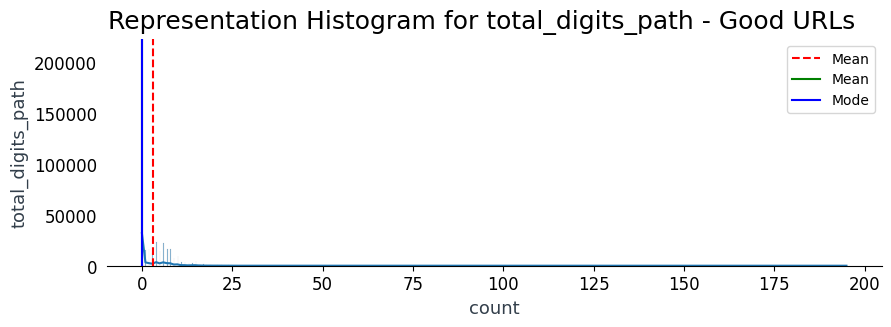

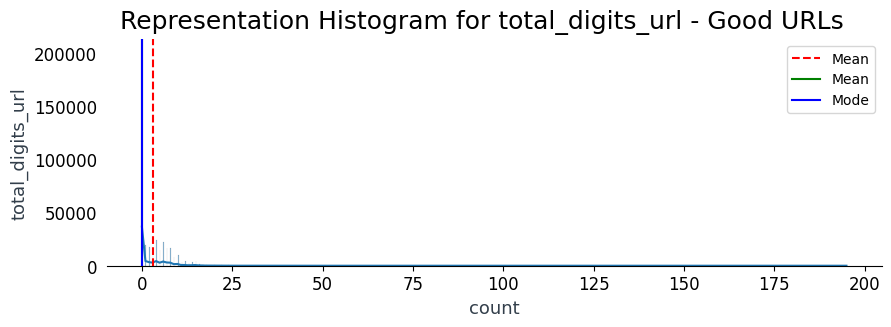

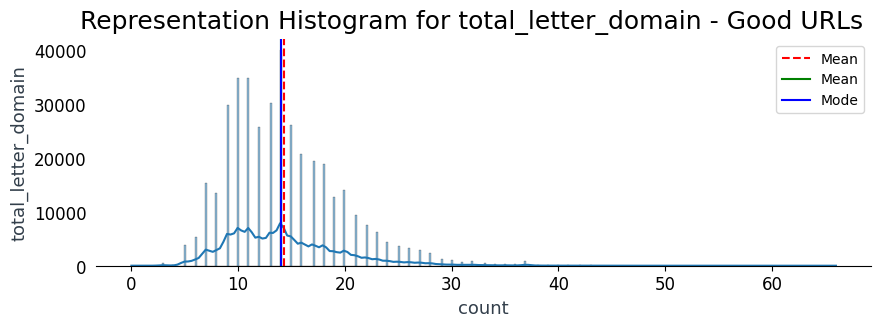

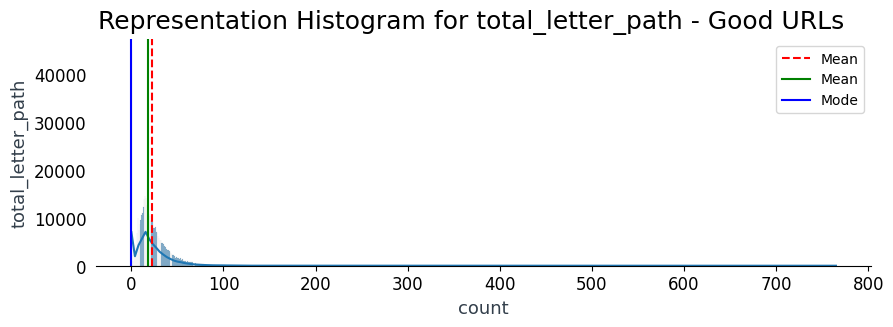

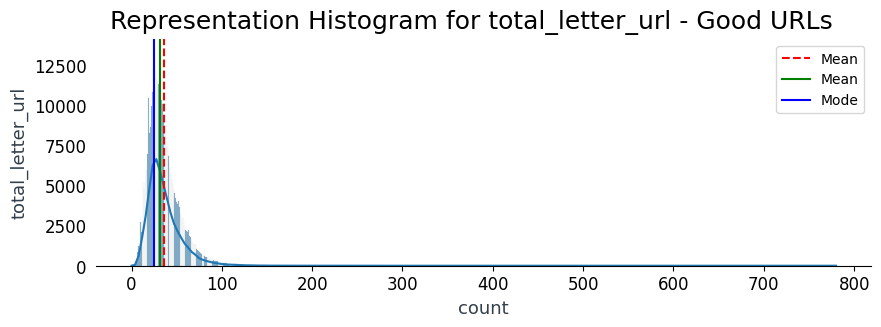

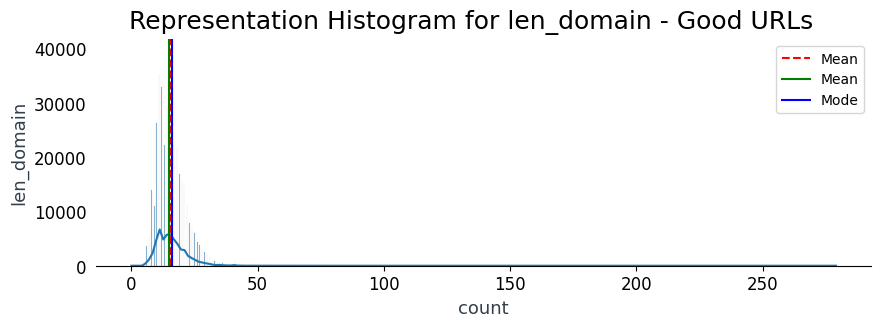

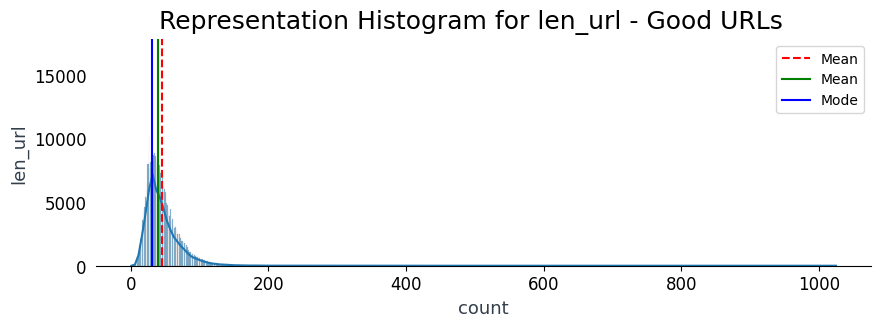

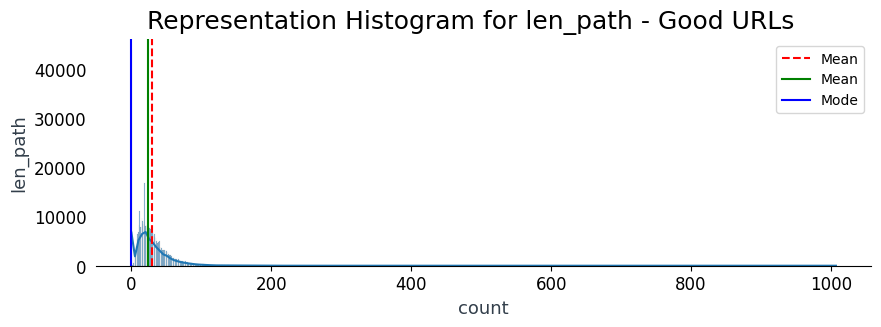

In [9]:
get_histplot_central_tendency(data.query('Label == "good"'), features, "Good URLs")

In [10]:
def dict_to_dataframe(dictionary: dict):
    pandas_to = {"name": [], "total": []}
    for name, value in dictionary.items():
        if len(name.replace(" ", "")) > 0:
            pandas_to["name"].append(name)
            pandas_to["total"].append(value)
    return pd.DataFrame(pandas_to).sort_values(by=['total'], ascending=False)

In [11]:
total_suffix_good = {}
total_suffix_bad = {}
for current, target in zip(data["URL"], data["Label"]):
    url_tldextract = tldextract.extract(current)
    suffix_tld = url_tldextract.suffix
    
    if target == "good":
        if suffix_tld not in total_suffix_good:
            total_suffix_good[suffix_tld] = 0
        total_suffix_good[suffix_tld] += 1
        
    if target == "bad":
        if suffix_tld not in total_suffix_bad:
            total_suffix_bad[suffix_tld] = 0
        total_suffix_bad[suffix_tld] += 1

In [12]:
df_tld_top_bad = dict_to_dataframe(total_suffix_bad)
df_tld_top_good = dict_to_dataframe(total_suffix_good)

In [13]:
def bar_plot_data(df: dict, subtitle: str, figsize=(5, 4), inverted_x=True):
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    for spline in ['top', 'right', 'left']:
        ax1.spines[spline].set_visible(False)

    sns.barplot(data=df, palette='cool', x="name", y="total")
    ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
    ax1.set_xlabel(f'{"name"}', fontsize=13, color = '#333F4B')
    ax1.set_ylabel(f'{"count"}', fontsize=13, color = '#333F4B')
    
    if inverted_x:
        plt.xticks(rotation=90)
        
    plt.plot(color="white", lw=3)
    fig.suptitle(subtitle, fontsize=18)
    plt.show()

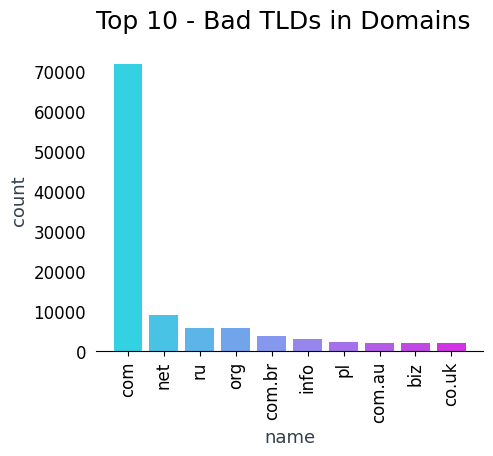

In [14]:
bar_plot_data(df=df_tld_top_bad.head(10), subtitle="Top 10 - Bad TLDs in Domains")

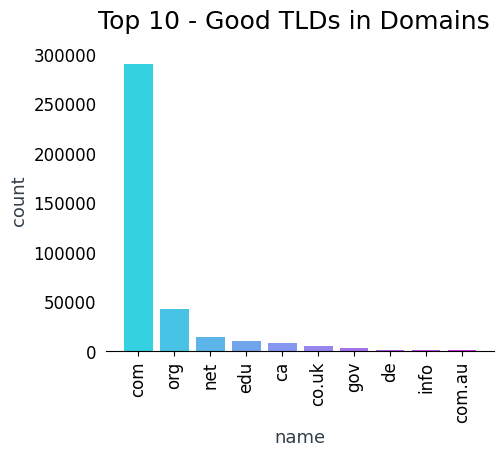

In [15]:
bar_plot_data(df=df_tld_top_good.head(10), subtitle="Top 10 - Good TLDs in Domains")

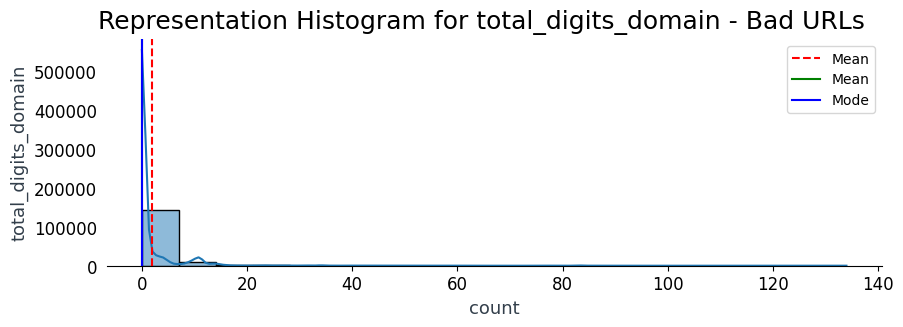

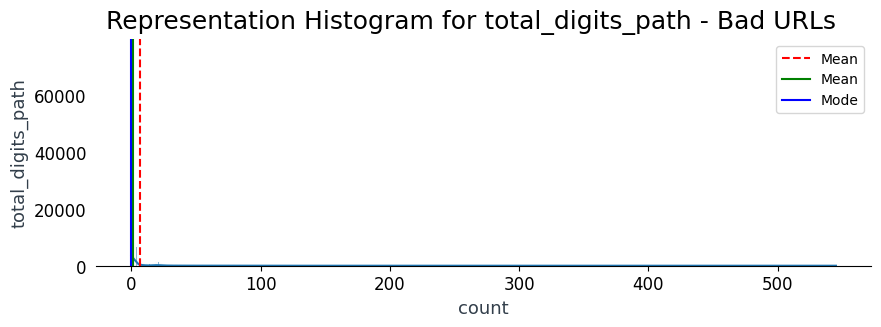

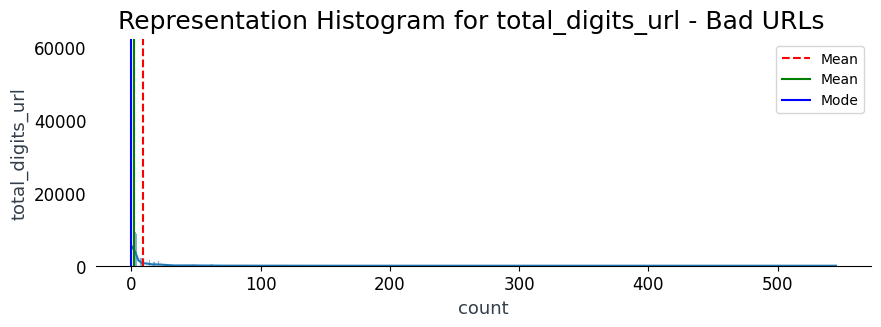

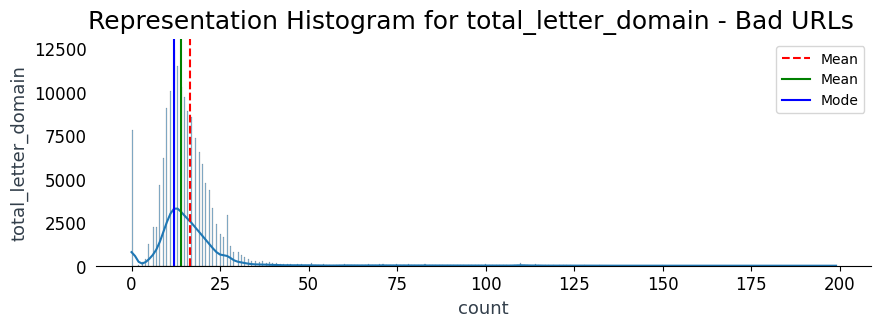

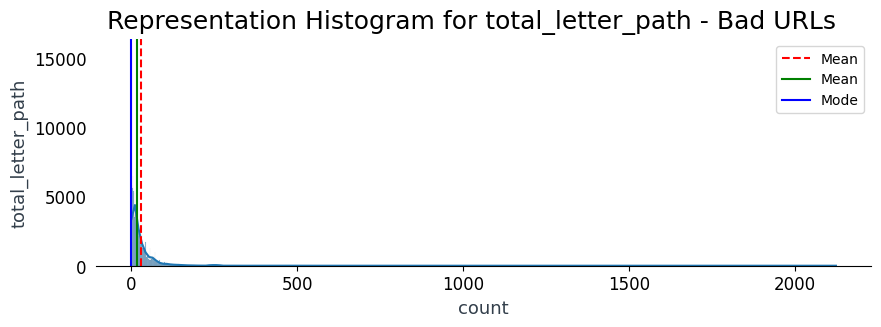

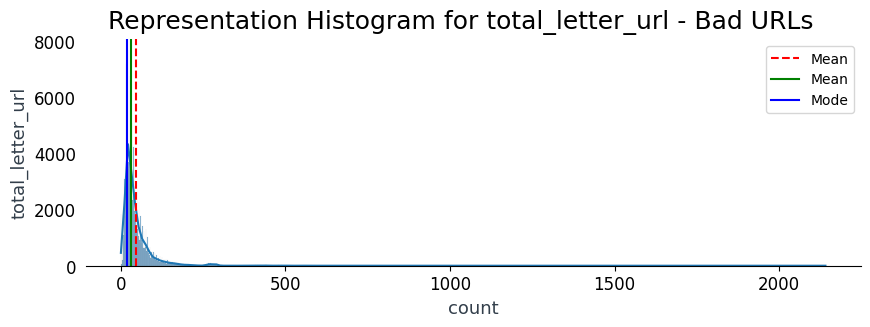

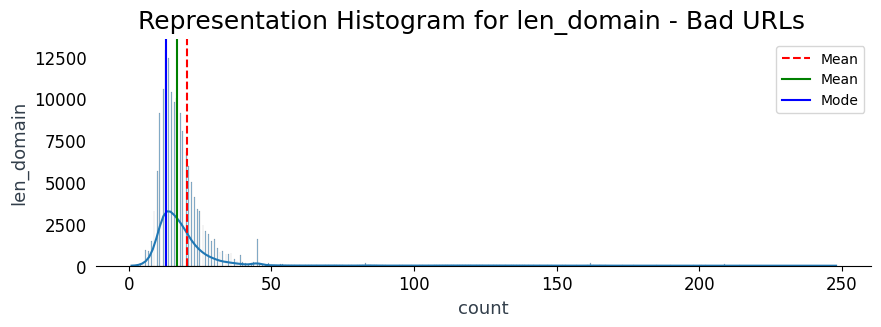

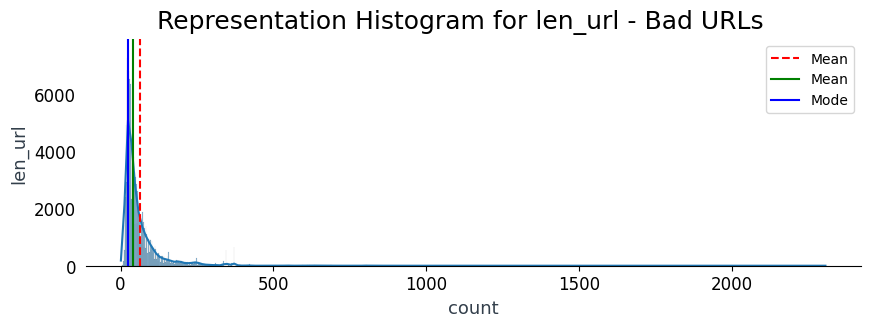

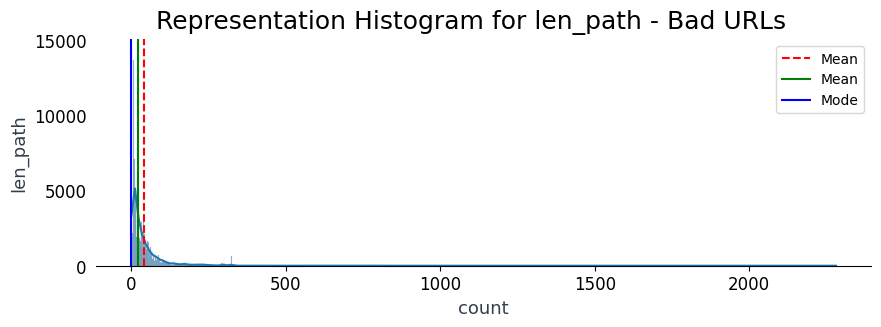

In [16]:
get_histplot_central_tendency(data.query('Label == "bad"'), features, "Bad URLs")

In [17]:
import nltk
import tldextract
from urllib.parse import urlparse

from nltk.util import ngrams

def generate_url_ngrams(n: int, url: str):
    url_formated = ''
    for index, char in enumerate(url):
        if index % n == 0:
            url_formated += ' '
        url_formated += char
    
    ngram = ngrams(sequence=nltk.word_tokenize(url_formated), n=n)
    ngram_url = {}
    for grams in ngram:
        for gx in grams:
            ngram_url[gx] = 1
    return ngram_url


def get_fields_url(url: str):
    try:
        static_features = dict()

        url_tldextract = tldextract.extract(url)
        url_urlparse = urlparse(f"http://{url}")

        url_metadata = [
            {"name": "domain", "string": url_tldextract.domain},
            {"name": "subdomain", "string": url_tldextract.subdomain},
            {"name": "suffix", "string": url_tldextract.suffix},
            {"name": "path", "string": url_urlparse.path},
            {"name": "params", "string": url_urlparse.params},
            {"name": "query", "string": url_urlparse.query},
            {"name": "fragment", "string": url_urlparse.fragment}
        ]

        static_features.update(generate_url_ngrams(2, url_tldextract.domain))
        for current in url_metadata:
            static_features[f'len_{current["name"]}'] = len(current["string"])
            for char_ in list(map(str, "-@_?=&./,")):
                static_features[f'char{char_}-{current["name"]}'] = current["string"].count(char_)

            if "domain" == current["name"] or "path" == current["name"]:
                total_letter, total_number = 0, 0
                for char_ in list(map(str, "abcdefghijklmnopqrstuvwxyz")):
                    total_letter += current["string"].lower().count(char_)

                for char_ in list(map(str, "0123456789")):
                    total_number += current["string"].lower().count(char_)

                static_features[f'letter_len_{current["name"]}'] = total_letter
                static_features[f'number_len_{current["name"]}'] = total_number
    except:
        return None         
    return static_features   

In [18]:
output = []
features = []

for url, target in zip(data["URL"], data["Label"]):
    features_json = get_fields_url(url)
    if features_json:
        if target == "bad":
            target_int = 1
        if target == "good":
            target_int = 0
            
        output.append(target_int)
        features.append(features_json)

In [19]:
len(features), len(output)

(549312, 549312)

In [20]:
pre_processor = DictVectorizer(sparse=True)
X = pre_processor.fit_transform(features)
X = csr_matrix(X)
X = X.tocsr()
y = np.array(output).astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, train_size=0.8)

In [22]:


def get_xgboost():
    return XGBClassifier(learning_rate=0.3, n_estimators=100,
                             objective='binary:logistic', seed=1,
                             silent=True, n_jobs=-1, max_depth=8,
                             colsample_bytree=1.0,
                             subsample=1.0)

In [23]:
model = get_xgboost()
model.fit(X_train, y_train)

[00:37:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:37:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1, silent=True, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
score = log_loss(y_test, model.predict_proba(X_test))
Y_pred = model.predict(X_test)
score_acc = accuracy_score(y_test, Y_pred)

print(f"Log loss: {score}")
print(f"Score acc: {score_acc}")

Log loss: 0.18307524376281314
Score acc: 0.9290024849130281
